In [15]:
 pip install rembg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 21.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 6.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


**Problem Statement: Bounding boxes Detection for Clothing Data using opencv-python and multiprocessing.**


**Import necessary libraries**

In [16]:
import pandas as pd
import os
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from rembg import remove
import joblib
from tqdm.notebook import tqdm
import shutil
import asyncio
from concurrent.futures import ThreadPoolExecutor
import multiprocessing
from multiprocessing import Pool, Manager
from PIL import Image
from sklearn.cluster import KMeans


2024-06-03 11:19:01.170293: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-03 11:19:01.170430: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-03 11:19:01.268136: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


**Data preprocessing**

In [17]:
data = pd.read_csv(r"/kaggle/input/clothing-dataset-full/images.csv")
data['org_path'] = data.apply(lambda row: f'/kaggle/input/clothing-dataset-full/images_original/{row["image"]}.jpg', axis=1)

data['grpd_path'] = data.apply(lambda row: f'/kaggle/working/sorted_images_/{row["label"]}/{row["image"]}.jpg', axis=1)
data = data.drop(['sender_id'],axis=1).reset_index(inplace=False)
data['kids']=data['kids'].apply(lambda x : 1 if x==True else 0)


grouped_df = data.groupby('label')['image'].apply(list).reset_index()
grouped_df['count']=grouped_df['image'].apply(lambda x : len(x))
dd = {label: image for label, image in zip(grouped_df['label'], grouped_df['image'])}

In [18]:
data.head()

,index,image,label,kids,org_path,grpd_path
0,0,4285fab0-751a-4b74-8e9b-43af05deee22,Not sure,0,/kaggle/input/clothing-dataset-full/images_ori...,/kaggle/working/sorted_images_/Not sure/4285fa...
1,1,ea7b6656-3f84-4eb3-9099-23e623fc1018,T-Shirt,0,/kaggle/input/clothing-dataset-full/images_ori...,/kaggle/working/sorted_images_/T-Shirt/ea7b665...
2,2,00627a3f-0477-401c-95eb-92642cbe078d,Not sure,0,/kaggle/input/clothing-dataset-full/images_ori...,/kaggle/working/sorted_images_/Not sure/00627a...
3,3,ea2ffd4d-9b25-4ca8-9dc2-bd27f1cc59fa,T-Shirt,0,/kaggle/input/clothing-dataset-full/images_ori...,/kaggle/working/sorted_images_/T-Shirt/ea2ffd4...
4,4,3b86d877-2b9e-4c8b-a6a2-1d87513309d0,Shoes,0,/kaggle/input/clothing-dataset-full/images_ori...,/kaggle/working/sorted_images_/Shoes/3b86d877-...


In [19]:
import shutil
import pandas as pd
import os

def copy_images(df):
    '''Sort images by label, copy into sorted directories of labels'''
    pth = []
    for index, row in df.iterrows():
        source_path = row['org_path']
        destination_path = row['grpd_path']
        
        if not os.path.exists(source_path):
            print(f"Source file {source_path} does not exist.")
            pth.append(source_path)
            continue
        
        destination_directory = os.path.dirname(destination_path)
        if not os.path.exists(destination_directory):
            os.makedirs(destination_directory)
        
        shutil.copy(source_path, destination_path)
    print(f"copied files from source_path to destination_path")
    return pth


In [20]:
notfound = copy_images(data)



copied files from source_path to destination_path


In [21]:
notfound

[]

In [22]:
# data[[~data['grpd_path'] is in notfound]]

In [23]:
class impp1():
    '''Image preprocessing class to perform operations from loading image to detecting cloth in the image and drawing bounding boxes
      - This class utilises opencv and rembg. 
        - Following are the main functions of this class:
            - rembg:This function takes np array image, removes background using remove model from rembg 
            - create mask:This function takes an image and generate a mask for detected object using k-means clustering.
            - convert_to_heatmap:Generate heatmap for an image.
            - process:using preprocessing function of this class , this function generates a new image with no background and bounding boxes drawn on the detected object 
            - add_padding: add padding to given image
            - find_draw_boxes: this function takes an image and returns detected object its coordinates and height and width
            - get_dominant_color and get_dominant_object: These function take an image and generate color and mask of origin image based upon dominant color.
            - display_images...
            
            Author: Arpita D
    '''
    def __init__(self):
      pass

    def load_image(self, image_path):
      image =cv2.imread(f'{image_path}')
      return image

    def rembg(self,image):
      bgrm = np.array(remove(image,bgcolor=(255,255,255,255)))
      return bgrm

    def add_padding(self,image,pad):
      padded_image = cv2.copyMakeBorder(image, pad,pad,pad,pad, cv2.BORDER_CONSTANT,value =(0,0,0))
      return padded_image

    def find_draw_boxes(self,image):
      gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
      _, binary = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY_INV)
      contours, hierarchy = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
      contour =  max(contours, key=cv2.contourArea)
      x, y, w, h = cv2.boundingRect(contour)
      result = cv2.rectangle(image, (x, y), (x + w, y + h), (0,0,0,255),20)
      return result,(x,y),(w,h)

    def display_image(self, image,title = "Title",origin=""):
      if origin == "file":
        image_rgb = self.load_image(image)
      else:
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      plt.figure(figsize=(12, 8))
      plt.imshow(image_rgb)
      plt.title=title
      plt.axis('off')
      plt.show()

    def process(self, image_path,origin=""):
      # if origin == 'file':
      image = self.load_image(image_path)
      padded_image = self.add_padding(image,50)
      masked_image = self.rembg(image)
      image_with_boxes = self.find_draw_boxes(masked_image)
      coord,dim = image_with_boxes[1],image_with_boxes[2]
      resx = image_with_boxes[0]
      resy = cv2.resize(image_with_boxes[0],(256,256))
#       binary_arr = Binary(pickle.dumps(resx, protocol=2))


      return resy,coord,dim

    def get_dominant_color(self,image, k=1):
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        pixels = image.reshape(-1, 3)
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(pixels)
        dominant_colors = kmeans.cluster_centers_.astype(int)
        return dominant_colors

    def create_mask(self,image, dominant_color, threshold=64):
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        lower_bound = np.clip(dominant_color-threshold, 0, 255)
        upper_bound = np.clip(dominant_color+threshold, 0, 255)
        mask = cv2.inRange(image_rgb, lower_bound, upper_bound)
        return mask
    
    def get_dominant_object(self,image):
        image = self.load_image(image)
        dominant_color = self.get_dominant_color(image, k=1)[0]
        mask = self.create_mask(image, dominant_color)
        result = cv2.bitwise_and(image, image, mask=mask)
#         result = self.convert_to_heatmap(result)
#         result = cv2.
        return result

    def convert_to_heatmap(self, image):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        heatmap = cv2.applyColorMap(image, cv2.COLORMAP_JET)
        return heatmap
    

ip1 = impp1()



In [24]:
# ip1.get_dominant_color(cv2.imread(data['grpd_path'][0]))

100%|████████████████████████████████████████| 176M/176M [00:00<00:00, 191GB/s]


(-0.5, 255.5, 255.5, -0.5)

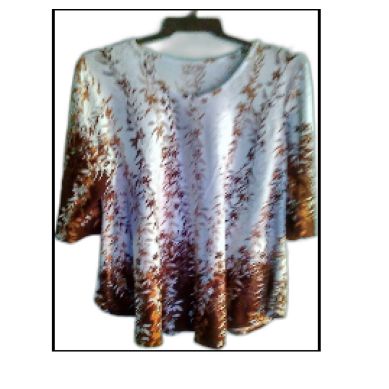

In [25]:
plt.imshow(ip1.process(data['grpd_path'][0])[0])
plt.axis('off')


In [26]:
notfound

[]

In [27]:
data = data[~data['grpd_path'].isin(notfound)].reset_index(drop=True)
# data = data.drop(['index'],axis = 1)
# _df.drop(['index'],axis=1)


In [28]:
data.shape

(5403, 6)

In [29]:
import os

def get_file_paths(directory):
    file_paths = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            file_paths.append(os.path.join(root, file))
    return file_paths

def chunk_list(lst, chunk_size):
    for i in range(0, len(lst), chunk_size):
        yield lst[i:i + chunk_size]

directory = '/kaggle/working/sorted_images_/'
file_paths = get_file_paths(directory)
chunks = list(chunk_list(file_paths, 32))
c=0
for i, chunk in enumerate(chunks):
    c+=1
print(f"Generated chunks :{i + 1}\nsize:32",)
#     for path in chunk:
#         print(path)
#     print()


Generated chunks :169
size:32


In [30]:
len(chunks)

169

In [31]:
class ImageProcessor():
    ''' parallel processing class to process images in chunks and save to working directory'''
    def __init__(self, image_batch):
        self.image_paths = image_batch
        self.results = []

    def worker(self, image_path):
        try:
            result = impp1().process(image_path)
#             opmm = f"kaggle/working/fprocessed/{image_path.split('/')[-1]}"
#             cv2.imwrite(opmm,result[0])
            return result
        except Exception as e:
            print(f"Error processing {image_path}: {e}")
            return None
        
    def process_images_in_parallel(self):
        with Manager() as manager:
            self.results = manager.list()
            with Pool(processes=multiprocessing.cpu_count()) as pool:
                self.results = pool.map(self.worker, self.image_paths)
        return list(self.results)



In [32]:
def get_chunks(data,csize):
  FILE_PATHS_PAIRS = []
  df4 = data.copy()
  FILE_PATHS_PAIRS = [(row['grpd_path'], row['image']) for _, row in tqdm(df4.iterrows()) if os.path.exists(row['grpd_path'])]        

  FILE_PATHS_PAIRS = np.array(FILE_PATHS_PAIRS, dtype=object)
  # print(f'FILE_PATHS_PAIRS shape: {FILE_PATHS_PAIRS.shape}')

#   CHUNK_SIZE = 32
  # num_chunks = (len(FILE_PATHS_PAIRS) + CHUNK_SIZE - 1) // CHUNK_SIZE  # This ensures rounding up

  CHUNKS = np.array_split(FILE_PATHS_PAIRS, csize)
  return chunks

In [33]:
import os
from PIL import Image

def save_results_to_directory(results, i):
    directory = f'processed_image_{i}'
    if not os.path.exists(directory):
        os.makedirs(directory)
    count = 0
    for j, result in enumerate(results):
        for i,j in enumerate(result):
            path = os.path.join(directory, f'image_{i}.png')
            cv2.imwrite(path,i)
            count+=1
            
    return count


In [34]:
data

,index,image,label,kids,org_path,grpd_path
0,0,4285fab0-751a-4b74-8e9b-43af05deee22,Not sure,0,/kaggle/input/clothing-dataset-full/images_ori...,/kaggle/working/sorted_images_/Not sure/4285fa...
1,1,ea7b6656-3f84-4eb3-9099-23e623fc1018,T-Shirt,0,/kaggle/input/clothing-dataset-full/images_ori...,/kaggle/working/sorted_images_/T-Shirt/ea7b665...
2,2,00627a3f-0477-401c-95eb-92642cbe078d,Not sure,0,/kaggle/input/clothing-dataset-full/images_ori...,/kaggle/working/sorted_images_/Not sure/00627a...
3,3,ea2ffd4d-9b25-4ca8-9dc2-bd27f1cc59fa,T-Shirt,0,/kaggle/input/clothing-dataset-full/images_ori...,/kaggle/working/sorted_images_/T-Shirt/ea2ffd4...
4,4,3b86d877-2b9e-4c8b-a6a2-1d87513309d0,Shoes,0,/kaggle/input/clothing-dataset-full/images_ori...,/kaggle/working/sorted_images_/Shoes/3b86d877-...
...,...,...,...,...,...,...
5398,5398,dfd4079d-967b-4b3e-8574-fbac11b58103,Shorts,0,/kaggle/input/clothing-dataset-full/images_ori...,/kaggle/working/sorted_images_/Shorts/dfd4079d...
5399,5399,befa14be-8140-4faf-8061-1039947e329d,Body,1,/kaggle/input/clothing-dataset-full/images_ori...,/kaggle/working/sorted_images_/Body/befa14be-8...
5400,5400,5379356a-40ee-4890-b416-2336a7d84061,Shorts,0,/kaggle/input/clothing-dataset-full/images_ori...,/kaggle/working/sorted_images_/Shorts/5379356a...
5401,5401,65507fb8-3456-4c15-b53e-d1b03bf71a59,Shoes,0,/kaggle/input/clothing-dataset-full/images_ori...,/kaggle/working/sorted_images_/Shoes/65507fb8-...


In [ ]:
import time
import numpy as np

start_time = time.time()

result_array = []

dat = data.copy()['grpd_path']
chunks = chunk_list(dat,32)
for i, chunk in enumerate(chunks):
    processor = ImageProcessor(chunk)
    results = processor.process_images_in_parallel()
    save_results_to_directory(results, i)
    cur= time.time()
    print('processed',i,cur - start_time)
    result_array.append(results)


end_time = time.time()
elapsed_time = end_time - start_time

print(f"Total time taken: {elapsed_time:.2f} seconds")

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


processed 0 41.834993839263916
processed 1 80.91421270370483
processed 2 122.77567076683044
processed 3 163.75921368598938
processed 4 204.33062744140625
processed 5 244.14710545539856
processed 6 285.44076013565063
processed 7 326.23745822906494
processed 8 366.3677682876587
processed 9 408.06681752204895
processed 10 448.5559470653534
processed 11 488.8125867843628
processed 12 529.7103905677795
processed 13 569.7782480716705
processed 14 610.6694846153259
processed 15 650.951544046402
processed 16 692.6295635700226
processed 17 733.0496454238892
processed 18 774.4929659366608
processed 19 813.7631220817566
processed 20 855.4169716835022
processed 21 895.1180124282837
processed 22 936.6354961395264
processed 23 978.3505582809448
processed 24 1020.53631067276
processed 25 1062.288348197937
processed 26 1102.2872586250305
processed 27 1141.8136847019196
processed 28 1183.221428155899
processed 29 1224.7407875061035
processed 30 1265.063238143921
processed 31 1304.6736688613892
processe

In [ ]:
print([len(results)])
      


In [ ]:
plt.imshow(results[0][0])
plt.axis('off')